## RECEPTI, *Projektna naloga pri predemtu Programiranje 1*
#### Marija Jezeršek

### Uvod:

V tej projektni nalogi analiziram recepte s strani "Kulinarika.net". S strani sem zajela podatke 12766 receptov iz kategorij juhe, solate, priloge, mesne jedi, zelenjavne jedi in sladice. Vsak recept ima podatke o imenu recepta in avtorja, času priprave, povprečni oceni, kategoriji, sestavinah in postopku priprave. Poleg tega ima vsak recept tudi svoj indeks, ki povezuje osnovne podatke recepta s podatki o sestavinah in postopku, ki so shranjeni v različnih CSV-datotekah.

Delovne hipoteze, ki sem si jih zastavila in so obravnavane v projektu, so:
- Kakšna je povezava med zahtevnostjo priprave in dolžino navodil, časom priprave ter številom različnih sestavin?
- Z uporabo naivnega Bayesovega klasifikatorja poskusim iz sestavin napovedati kategorijo jedi.

In [42]:
# naložimo paket
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# ker bomo delali z velikimi razpredelnicami, povemo, da naj se vedno izpiše le 10 vrstic
pd.set_option('display.max_rows', 10)

Ker nam tudi Kulinarika poda svojo oceno zahtevnosti (sklepam, da gre za (subjektivno) oceno avtorja recepta), bom s shranjenih html strani najprej pridobila še podatke o tem, da jih bom kasneje lahko primerjala s svojo oceno.

In [242]:
recepti = pd.read_csv('podatki_z_indeksi.csv')

recepti['predvidena_tezavnost'] = 0
predvidena_tezavnost = recepti['predvidena_tezavnost']

for vrstica in tqdm(recepti.iloc, total=len(recepti)):
    pot = f"html_strani/{vrstica['indeks']}.html"

    with open(pot, 'r', encoding='utf-8') as d:
        vsebina = d.read()
    vzorec_zahtevnost = re.compile(r"""<img src='/grafika6/ikona-utez.png'""", re.DOTALL)
    z = re.findall(vzorec_zahtevnost, vsebina)

    predvidena_tezavnost[recepti['indeks'] == vrstica['indeks']] = len(z)


recepti.to_csv('podatki_z_indeksi.csv')

  0%|          | 0/12766 [00:00<?, ?it/s]C:\Users\Marija\AppData\Local\Temp\ipykernel_12740\3744588564.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predvidena_tezavnost[recepti['indeks'] == vrstica['indeks']] = len(z)
100%|██████████| 12766/12766 [00:38<00:00, 330.35it/s]


Text(0, 0.5, 'število receptov dane težavnosti')

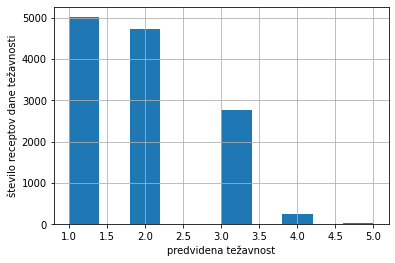

In [43]:
recepti = pd.read_csv('podatki_z_indeksi.csv')

a = recepti["predvidena_tezavnost"]
plt = a.hist()
plt.set_xlabel("predvidena težavnost")
plt.set_ylabel("število receptov dane težavnosti")


Kulinarika torej večino receptov oceni kot enostavne ... Kaj pa mi?

### Indeks zahtevnosti priprave:

Po moji oceni je zahtevnost priprave odvisna od časa priprave $ t $, dolžine opisa postopka priprave $ l $ in številom različnih sestavin $ n $, ki jih potrebuješ za pripravo jedi. Na podlagi teh parametrov bom za vsak recept izračunala indeks zahtevnosti priprave recepta $ z $ po formuli:
$$ z =  t l \log n  $$
Težavnost namreč narašča v odvisnosti od vseh treh parametrov, s tem da po moji (subjektivni) oceni zahtevnost s časom priprave narašča linearno, prav tako s  količino stvari, ki jih moraš narediti, da prišraviš jed (tj. dolžina opisa postopka). Dodatne sestavine pa so ponavadi le še dodatne začimbe, ki jih dodaš jedi, težavnosti recepta pa ne spremenijo bistveno, zato logaritemska odvisnost.

Najprej si poglejmo nekaj osnovnih lastnosti naših podatkov, da si ustvarimo predstavo, s čim sploh delamo. Zanimajo nas:
- povprečno število sestavin, dolžina navodil in čas priprave jedi,
- dolžina navodil v odvisnost od števila sestavin.

In [109]:
# Pripravimo si nekaj funkcij, tabel in stolpcev v tabeli, ki jih bomo potrebovali za analizo:

recepti = pd.read_csv('podatki_z_indeksi.csv')
sestavine = pd.read_csv('sestavine.csv')
postopki = pd.read_csv('postopki.csv')

def cas_v_minutah(niz):
    """ Pretvori čas priprave v celo število minut, potrebnih za priprvo. """
    if "ur" in niz and "min" in niz:
        return str(int(re.findall(r"\d+", niz)[0]) * 60 + int(re.findall(r"\d+", niz)[1]))
    elif niz[-3:] == 'min':
        return str(niz.split(' ')[0])
    elif niz[-3:] in {'ura', ' ur', 'ure', "uri"}:
        return str(int(re.findall(r"\d+", niz)[0]) * 60)
    else:
        return None

def povp(df):
    return (df - df.mean()) / df.std()

def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

recepti['čas_priprave_min'] = recepti['čas_priprave'].apply(cas_v_minutah)
maska = ~recepti["čas_priprave_min"].isnull()

In [110]:
n = sestavine.groupby("indeks").size()
recepti["st_sestavin"] = n
povprecno_st_sestavin = n.mean()

postopki['dolzina'] = postopki.postopek.str.split(" ").str.len()
l = postopki.groupby("indeks").sum("dolzina").dolzina
recepti["dolzina_navodil"] = l
povprecna_dolzina_navodil = l.mean()

t = pd.to_numeric(recepti["čas_priprave_min"])[maska]
povprecen_cas_priprave = t.mean()

povprecno_st_sestavin, povprecna_dolzina_navodil, povprecen_cas_priprave


(12.713927620241266, 97.70037599874667, 69.50808393532851)

Povprečno število sestavin je torej slabih 13, dolžina navodil pa 98 besed.

Poglejmo še korelacijo dolžine navodil in števila sestavin danega recepta:

<AxesSubplot: xlabel='dolzina_navodil', ylabel='st_sestavin'>

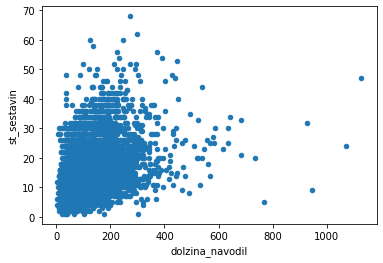

In [111]:
recepti.sort_values('dolzina_navodil').plot.scatter(x='dolzina_navodil', y='st_sestavin')

Odvisnost ni linearna, temveč so recepti zgoščeni pri manj sestavinah in krajših navodilih, nekaj pa jih odstopa v vsako smer.

Izračun indeksa zahtevnosti:

In [112]:
t = pd.to_numeric(recepti["čas_priprave_min"])[maska]

t_norm = povp(t)

postopki['dolzina'] = postopki.postopek.str.split(" ").str.len()
l = postopki.groupby("indeks").sum("dolzina").dolzina[maska]
l_ = l

l_norm = povp(l_)

n = sestavine.groupby("indeks").size()[maska]
n_ = np.log(n)

n_norm = povp(n_)

zahtevnost = recepti['čas_priprave_min'].copy()
zahtevnost[maska] =  (t_norm * l_norm * n_norm)
recepti["zahtevnost1"] = povp(zahtevnost)


Zdaj smo dobili porazdelitev receptov glede na njihovo zahtevnost, izračunano po naši formuli in standardno porazdeljene. Sedaj bomo odstranili nekaj največjih in najmanjših, jim dali oceno 5 oz. 0, ostale pa normirali od 0 do 5.

C:\Users\Marija\AppData\Local\Temp\ipykernel_21548\2607440804.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recepti["zahtevnost1"][maska_na] = zahtevnost_brez_na


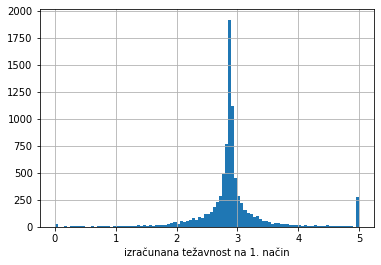

In [70]:
odstrani_zg, odstrani_sp = 20, 100

maska_na = ~recepti['zahtevnost1'].isna()
zahtevnost_brez_na = recepti['zahtevnost1'][maska_na]
sez = zahtevnost_brez_na.copy().to_numpy()
sez.sort()
lower, upper = sez[odstrani_zg], sez[-odstrani_sp]

maska = (zahtevnost_brez_na < upper) & (zahtevnost_brez_na > lower)

zahtevnost_brez_na[maska] = 5 * minmax(zahtevnost_brez_na[maska])
zahtevnost_brez_na[zahtevnost_brez_na >= upper] = 5
zahtevnost_brez_na[zahtevnost_brez_na <= lower] = 0

# Stolpec izračunanih zahtevnosti dodamo v tabelo
recepti["zahtevnost1"][maska_na] = zahtevnost_brez_na

# Histogram zahtevnosti:
a = zahtevnost_brez_na
plt = a.hist(bins=100)
plt.set_xlabel("izračunana težavnost na 1. način")

Dobili smo ocene zahtevnosti analiziranih receptov glede na izbrani kriterij.

Sedaj pa nas zanima še primerjava med našimi izračuni in ocenami, ki so jih predvideli avtorji receptov.
Izračunamo razmerje $z/t$, kjer je $z$ zahtevnost, izračunana po naših postopkih, $t$ pa predvidena težavnost, podana na strani. Odstopanje zahtevnosti podem izrazimo kot $1 - z/t$.

In [47]:
recepti["odstopanje_zahtevnosti1"] = 1 - recepti["zahtevnost1"] / recepti["predvidena_tezavnost"]

Text(0, 0.5, 'število elementov, ki odstopajo')

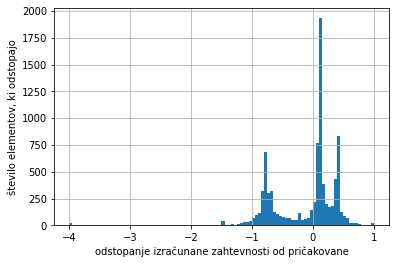

In [48]:
%matplotlib inline

a = recepti["odstopanje_zahtevnosti1"]
plt = a.hist(bins=100)
plt.set_xlabel("odstopanje izračunane zahtevnosti od pričakovane")
plt.set_ylabel("število elementov, ki odstopajo")

Opazimo lahko, da so na ta način dobljena odstopanja večinoma med vrednostima + 1 in - 1. Večina receptov na ta način dobi oceno malce pod 2.

Preverimo lahko še, kolikšna so odstopanja pri predvideno lažjih oz. težjih receptih.

Text(0.5, 0, 'izračunana zahtevnost')

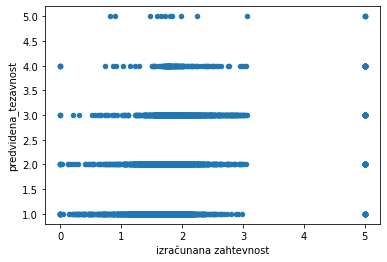

In [56]:
recepti.sort_values('zahtevnost').plot.scatter(x='zahtevnost', y='predvidena_tezavnost').set_xlabel("izračunana zahtevnost")

Oceno težavnosti poskusimo določiti še na drug način: postavimo kriterij, po katerem od 0 do 5 ocenimo težavnost časa priprave, števila sestavin in dolžine postopka. Nato izračunamo njihovo povprečje, kar postane skupna ocena zahtevnosti.

Kako sem dobila spodnje kriterije?
Za vsako od kategorij sem določila (si izmislila) mejo, ki jo mora recept doseči, da si zasluši določeno oceno v dani kategoriji (npr. kriterij za dolzino postopka d: d <= 10 -> 0, 50 -> 1, 100 -> 2, 200 -> 3, 300 -> 4, 435 -> 5). S pomočjo spletne aplikacije sem nato zmodelirala monotone funkcije, ki tečejo skozi dane točke in jih vnesla v kriterije.

In [34]:
def casovni_kriterij(cas_v_minutah):
    cas_v_minutah = int(cas_v_minutah)
    if cas_v_minutah >= 69:
        return 5
    else:
        return (0.0971636 * (cas_v_minutah ** 0.944257)) - 0.383887

def sestavine_kriterij(st_sestavin):
    if st_sestavin >= 11:
        return 5
    else:
        return (st_sestavin - 3) / 2 

def postopek_kriterij(dolzina_postopka):
    if dolzina_postopka <= 10:
        return 0
    elif dolzina_postopka >= 435:
        return 5
    else:
        return (0.257975 * (dolzina_postopka ** 0.513715)) - 0.853943


Text(0, 0.5, 'število elementovdoločene zahtevnosti')

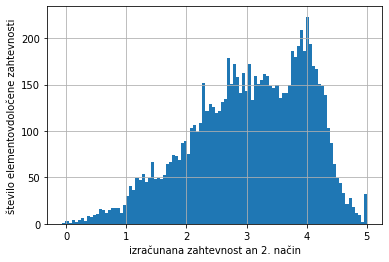

In [59]:
recepti['čas_priprave_min'] = recepti['čas_priprave'].apply(cas_v_minutah)
maska = ~recepti["čas_priprave_min"].isnull()
t = recepti["čas_priprave_min"][maska].apply(casovni_kriterij)

postopki['dolzina'] = postopki.postopek.str.split(" ").str.len()
l = postopki.groupby("indeks").sum("dolzina").dolzina[maska]
l = l.apply(postopek_kriterij)

n = sestavine.groupby("indeks").size()[maska]
n = n.apply(sestavine_kriterij)



zahtevnost = recepti['čas_priprave_min'].copy()
zahtevnost[maska] =  (t + l + n) / 3
recepti["zahtevnost2"] = zahtevnost

a = pd.to_numeric(recepti["zahtevnost2"])
plt = a.hist(bins=100)
plt.set_xlabel("izračunana zahtevnost an 2. način")
plt.set_ylabel("število elementovdoločene zahtevnosti")
# _ = plt.hist(pd.to_numeric(recepti["zahtevnost1"]), bins=100)

Text(0, 0.5, 'število elementov, ki odstopajo')

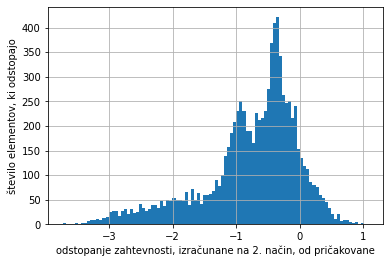

In [60]:
recepti["odstopanje_zahtevnosti2"] = 1 - recepti["zahtevnost2"] / recepti["predvidena_tezavnost"]

a = recepti["odstopanje_zahtevnosti2"]
plt = a.hist(bins=100)
plt.set_xlabel("odstopanje zahtevnosti, izračunane na 2. način, od pričakovane")
plt.set_ylabel("število elementov, ki odstopajo")

Po tej oceni so recepti v povprečju zahtevnejši, pa tudi odstopanja s predvivenimi vrednostmi so večja.

Zanimivo je tudi, da je že na Kulinariki zelo malo receptov ocenjenih z oceno 5. Lako pogledamo, kateri so to in ali imajo morda kaj skupnega.

In [61]:
pd.set_option('display.max_rows', 35)

najzahtevnejsi = recepti.loc[recepti['predvidena_tezavnost'] == 5]
najzahtevnejsi

,Unnamed: 0,indeks,povezava,ime,avtor,čas_priprave,povprečna_ocena,kategorija,predvidena_tezavnost,čas_priprave_min,zahtevnost1,zahtevnost2,odstopanje_zahtevnosti2
972,972,972,'/recepti/mesne-jedi/govedina/boeuf-bourguigno...,Boeuf bourguignon,archi,4+ ur,Unknown,meso,5,240,5.0,5.0,0.0
1480,1480,1480,'/recepti/mesne-jedi/ostalo/nadevan-kunec/67/',Nadevan kunec,Unknown,Unknown,Unknown,meso,5,None,None,None,NaN
1809,1809,1809,'/recepti/mesne-jedi/drobnica/kulinaricne-zapo...,Kulinarične zapovedi po moje,anamarija1,4+ ur,Unknown,meso,5,240,1.983309,1.983309,0.603338
2095,2095,2095,'/recepti/mesne-jedi/drobnica/z-jagnjetino-pol...,Z jagnjetino polnjeno zelje,Marinka,2 uri,Unknown,meso,5,120,4.161229,4.161229,0.167754
2137,2137,2137,'/recepti/mesne-jedi/teletina/nadevane-telecje...,Nadevane telečje prsi,Unknown,Unknown,Unknown,meso,5,None,None,None,NaN
2214,2214,2214,'/recepti/mesne-jedi/divjacina/kvasena-srna-s-...,Kvašena srna s smetano,Unknown,Unknown,Unknown,meso,5,None,None,None,NaN
2741,2741,2741,'/recepti/zelenjavne-jedi/krompirjev-narastek-...,Krompirjev narastek z mesom,zelenjavček,15 min,Unknown,zelenjava,5,15,2.629248,2.629248,0.47415
3282,3282,3282,'/recepti/zelenjavne-jedi/zeljnati-zvitki-po-v...,Zeljnati zvitki po vietnamsko,Marinka,Unknown,Unknown,zelenjava,5,None,None,None,NaN
4726,4726,4726,'/recepti/solate/kimci-v-sojini-omaki/9518/',Kimči v sojini omaki,Marinka,Unknown,Unknown,solata,5,None,None,None,NaN
5052,5052,5052,'/recepti/sladice/pecivo/pistacijeva-fantazija...,Pistacijeva fantazija,CakeOClock_Urška,4+ ur,Unknown,sladice,5,240,4.667551,4.667551,0.06649


In [62]:
delezi_po_kategorijah = najzahtevnejsi.groupby("kategorija").size() / len(najzahtevnejsi)

delezi_po_avtorjih = najzahtevnejsi.groupby("avtor").size() / len(najzahtevnejsi)

delezi_po_kategorijah.sort_values(ascending=False), delezi_po_avtorjih.sort_values(ascending=False)

(kategorija
 sladice      0.71875
 meso         0.18750
 zelenjava    0.06250
 solata       0.03125
 dtype: float64,
 avtor
 Marinka             0.12500
 Unknown             0.12500
 631141              0.06250
 klavdijaF           0.06250
 anja                0.06250
 archi               0.03125
 ursa40              0.03125
 sonetar             0.03125
 kača                0.03125
 jasna47             0.03125
 harmonija           0.03125
 burjovec            0.03125
 asam                0.03125
 anamarija1          0.03125
 CakeOClock_Urška    0.03125
 anagerzina          0.03125
 Stošce              0.03125
 ROKCO               0.03125
 Pitončica           0.03125
 MaksP96             0.03125
 Lenka Kuč           0.03125
 DUŠANKA             0.03125
 zelenjavček         0.03125
 dtype: float64)

Opazimo, da:
- si 12,5 % % najzahtevnejših receptov lasti Marinka
- največ najzahtevnejšihz receptov je sladic (71 %), sledijo jim mesne jedi (19 %)

Poglejmo še, kakšne rezultate dobimo z našo (1.) oceno težavnosti.

In [63]:
najzahtevnejsi_nasa_ocena = recepti.loc[recepti['zahtevnost1'] == 5]

delezi_po_kategorijah = najzahtevnejsi_nasa_ocena.groupby("kategorija").size() / len(najzahtevnejsi_nasa_ocena)
delezi_po_avtorjih = najzahtevnejsi_nasa_ocena.groupby("avtor").size() / len(najzahtevnejsi_nasa_ocena)

delezi_po_kategorijah.sort_values(ascending=False), delezi_po_avtorjih.sort_values(ascending=False)

(kategorija
 sladice      0.833333
 meso         0.083333
 zelenjava    0.083333
 dtype: float64,
 avtor
 Vendelina jr.    0.458333
 Krepko           0.083333
 Ave_             0.041667
 Azra17           0.041667
 Chushi           0.041667
 Katja D          0.041667
 MaksP96          0.041667
 Pelicious        0.041667
 Stošce           0.041667
 archi            0.041667
 midvakuhava      0.041667
 taral            0.041667
 zvezdica55       0.041667
 dtype: float64)

Pri naši oceni težavnosti pa se delež sladic poveča na, največ najzavtevnejših receptov (46 %) pa napiše Vendelina jr.

### Napoved kategorije iz sestavin z uporabo naivnega Bayesovega klasifikatorja

Z uporabo naivnega Bayesovega klasifikatorja iz sestavin poskusimo določiti kategorijo jedi.

Hipoteza: za sladice in mesne jedi, katerih večinska sestavina je meso, bo napoved precej natančna, za ostale kategorije pa ne tako zelo.

In [72]:
recepti = pd.read_csv('podatki_z_indeksi.csv')
sestavine = pd.read_csv('sestavine.csv')

zdruzena = pd.merge(recepti, sestavine)
zdruzena.drop(["povezava", "avtor", "čas_priprave", "povprečna_ocena", "predvidena_tezavnost"], axis=1)

,Unnamed: 0,indeks,ime,kategorija,količina,sestavina
0,0,0,Cmočki šarenke v žametni bučni juhi,juha,2 kosa,šarenke
1,0,0,Cmočki šarenke v žametni bučni juhi,juha,2 kosa,čebule
2,0,0,Cmočki šarenke v žametni bučni juhi,juha,NaN,česen
3,0,0,Cmočki šarenke v žametni bučni juhi,juha,1 šopek,peteršilja
4,0,0,Cmočki šarenke v žametni bučni juhi,juha,400 g,krompirja
...,...,...,...,...,...,...
162301,12765,12765,Jagodni semifreddo,sladice,1,jajce
162302,12765,12765,Jagodni semifreddo,sladice,100 g,mlečne čokolade
162303,12765,12765,Jagodni semifreddo,sladice,400 g,jagod
162304,12765,12765,Jagodni semifreddo,sladice,500 ml,smetane za stepanje


Najprej izračunamo verjetnost, da se določena kategorija sploh pojavi.

In [114]:
verjetnosti_kategorij = recepti.groupby('kategorija').count()["ime"] / len(recepti)
verjetnosti_kategorij

kategorija
juha         0.049977
meso         0.139825
priloga      0.070265
sladice      0.624393
solata       0.043788
zelenjava    0.071753
Name: ime, dtype: float64

Sedaj bomo izračunali verjetnost, da se sestavina pojavi v posameznih kategorijah.

Najprej iz sestavin odstranimo morebitne povezave na reklame in opombe v oklepajih, ki jih dodajajo nekateri avtorji receptov:

In [74]:
def odstrani_html(x):
    return re.sub('<[^<]+?>', '', str(x))

def odstrani_opombe(x):
    return re.sub('\(.*?\)', '', str(x))

zdruzena["sestavina"] = zdruzena["sestavina"].apply(odstrani_html)
zdruzena["sestavina"] = zdruzena["sestavina"].apply(odstrani_opombe)

zdruzena.drop(["povezava", "avtor", "čas_priprave", "povprečna_ocena", "predvidena_tezavnost"], axis=1)

,Unnamed: 0,indeks,ime,kategorija,količina,sestavina
0,0,0,Cmočki šarenke v žametni bučni juhi,juha,2 kosa,šarenke
1,0,0,Cmočki šarenke v žametni bučni juhi,juha,2 kosa,čebule
2,0,0,Cmočki šarenke v žametni bučni juhi,juha,NaN,česen
3,0,0,Cmočki šarenke v žametni bučni juhi,juha,1 šopek,peteršilja
4,0,0,Cmočki šarenke v žametni bučni juhi,juha,400 g,krompirja
...,...,...,...,...,...,...
162301,12765,12765,Jagodni semifreddo,sladice,1,jajce
162302,12765,12765,Jagodni semifreddo,sladice,100 g,mlečne čokolade
162303,12765,12765,Jagodni semifreddo,sladice,400 g,jagod
162304,12765,12765,Jagodni semifreddo,sladice,500 ml,smetane za stepanje


Sedaj iz sestavin izluščimo njihove korene.

In [75]:
def koren_besede(beseda):
    beseda = ''.join(znak for znak in beseda if znak.isalpha())
    if not beseda:
        return '$'
    beseda = beseda.removesuffix('ga')
    beseda = beseda.rstrip('hgvn')
    beseda = beseda.rstrip('aeiou')
    beseda = beseda.strip('0123456789(),;-')
    return beseda

def koreni_besed(niz):
    return pd.Series(sorted({
        koren_besede(beseda) for beseda in niz.lower().split() if beseda
    }))

In [76]:
zdruzena.sestavina

0                     šarenke
1                      čebule
2                       česen
3                  peteršilja
4                   krompirja
                 ...         
162301                  jajce
162302        mlečne čokolade
162303                  jagod
162304    smetane za stepanje
162305              sladkorja
Name: sestavina, Length: 162306, dtype: object

In [77]:
koreni_sestavine = zdruzena.sestavina.apply(koreni_besed)

C:\Users\Marija\AppData\Local\Temp\ipykernel_21548\2255164173.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(sorted({


V tabelo receptov vsakemu receptu dodamo še seznam korenov sestavin, ki nastopajo v njem:

In [78]:
sez = []

for i in range(len(recepti)):
    recept = i
    sestavine_recept = koreni_sestavine[sestavine['indeks'] == recept].to_numpy().flatten()
    sestavine__recept = [*filter(lambda v: v==v, sestavine_recept)]

    sez.append(sestavine__recept)


recepti["sestavine"] = sez


In [79]:
sestavine = []
kategorije = []

for sez, kat in recepti[["sestavine", "kategorija"]].iloc:
    for sest in sez:
        if sest != '$':
            sestavine.append(sest)
            kategorije.append(kat)

koreni_po_kategorijah = pd.DataFrame(list(zip(sestavine, kategorije)), columns =['koren', 'kategorija'])
koreni_po_kategorijah

,koren,kategorija
0,šarenk,juha
1,čebul,juha
2,čes,juha
3,peteršilj,juha
4,krompirj,juha
...,...,...
299142,jagod,sladice
299143,smetan,sladice
299144,stepanj,sladice
299145,z,sladice


In [80]:
pojavitve_korenov_po_kategorijah = koreni_po_kategorijah.groupby(['koren', 'kategorija']).size().unstack()
pojavitve_korenov_po_kategorijah

kategorija,juha,meso,priloga,sladice,solata,zelenjava
koren,,,,,,
,213.0,713.0,529.0,4417.0,281.0,560.0
abc,NaN,NaN,NaN,2.0,NaN,NaN
ac,NaN,NaN,NaN,3.0,NaN,NaN
acet,NaN,NaN,2.0,NaN,NaN,NaN
acetatn,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...
žlčk,1.0,NaN,NaN,1.0,NaN,NaN
žogic,NaN,NaN,NaN,1.0,NaN,NaN
žrebičk,NaN,1.0,NaN,NaN,NaN,NaN


In [81]:
verjetnosti_korenov_po_kategorijah = (pojavitve_korenov_po_kategorijah / recepti.groupby('kategorija').size()).fillna(0.0001)
verjetnosti_korenov_po_kategorijah

kategorija,juha,meso,priloga,sladice,solata,zelenjava
koren,,,,,,
,0.333856,0.399440,0.589744,0.554134,0.502683,0.611354
abc,0.000100,0.000100,0.000100,0.000251,0.000100,0.000100
ac,0.000100,0.000100,0.000100,0.000376,0.000100,0.000100
acet,0.000100,0.000100,0.002230,0.000100,0.000100,0.000100
acetatn,0.000100,0.000100,0.000100,0.000125,0.000100,0.000100
...,...,...,...,...,...,...
žlčk,0.001567,0.000100,0.000100,0.000125,0.000100,0.000100
žogic,0.000100,0.000100,0.000100,0.000125,0.000100,0.000100
žrebičk,0.000100,0.000560,0.000100,0.000100,0.000100,0.000100


S pomočjo nastavljenih spremenljivk in naivnega Bayesovega klasifikatorja lahko preprosto izračunamo verjetnost, da je nek recept določene kategorije na podlagi sestavin. Deluje tako, da med """ """ vstaviš sestavine, ki nastopajo v receptu, katerega kategorija te zanima.

In [116]:
def doloci_kategorijo_iz_sestavin(sestavine_recepta):
    koreni_recepta = koreni_besed(sestavine_recepta)

    stevci_verjetnosti_kategorije_recepta = (verjetnosti_korenov_po_kategorijah[
        verjetnosti_korenov_po_kategorijah.index.isin(koreni_recepta)
    ].prod() * verjetnosti_kategorij)

    return stevci_verjetnosti_kategorije_recepta.sort_values(ascending=False)

Sedaj bom delovanje preiskusila na po enem receptu vsake kategorije, ki pa ga ne bom vzela s Kulinarike.

Juha: ciganski golaž
Mesna jed: piščanec v pivskem testu
Zelenjavna jed: pečeni krompirjevi polpeti
Priloga: pražen krompir
Solata: pisana poletna solata s čičeriko
Sladica: rolada s smetano in marmelado

In [117]:
sestavine_juha = """govejega mesa
sončničnega olja
rumenega korenčka
rdečega korenčka
rumene kolerabe
gomolja zelene
pastinaka
čebule
česna
žlica bele moke tip 500
žlica paradižnikove mezge
sladke rdeče mlete paprike
kislih kumaric
listi lovorja
vode
sol po okusu
poper po želji"""

sestavine_meso = """
piščančjih prsi
soli
bel poper po okusu
moke
Fala suhega kvasa
soli
piva
"""

sestavine_zelenjava = """
Krompir
Sol
Maslo
Poper
Česen - v prahu
Kravje mleko - polnomastno
Parmezan
Kisla smetana
Jajce - kokošje
Drobtine
Olje - sončnično
"""

sestavine_priloga = """
Krompir
Sol
Čebula
Olje - sončnično
Poper
Voda
Jušna kocka
"""

sestavine_solata = """
čičerike
zrela paradižnika
srednje velika kumara
rdeče čebule
nekaj vejic svežega peteršilja
sok polovice llimone (po potrebi tudi več)
olivnega olja
sol po okusu
feta sira
popraženih sezamovih semen
"""

sestavine_sladica = """
masla
navadne temne čokolade
ruma
rjavega sladkorja
vanilijevega sladkorja
moke
kakava v prahu
jajc
masla za pekač
"""

sestavine_kategorije = [("juhe", sestavine_juha), ("mesne jedi", sestavine_meso), ("zelenjavne jedi", sestavine_zelenjava), ("priloge", sestavine_priloga), ("solate", sestavine_solata), ("sladice", sestavine_sladica)]
for kategorija, sestavine_recepta in sestavine_kategorije:
    print(kategorija, doloci_kategorijo_iz_sestavin(sestavine_recepta))

juhe kategorija
zelenjava    1.376169e-30
meso         3.240657e-34
juha         1.565088e-35
priloga      3.613969e-36
solata       1.230836e-38
sladice      4.250826e-61
dtype: float64
mesne jedi kategorija
zelenjava    3.465829e-13
meso         3.272408e-13
solata       2.567066e-13
priloga      2.854162e-16
sladice      7.892452e-20
juha         4.936219e-20
dtype: float64
zelenjavne jedi kategorija
zelenjava    1.589695e-18
solata       4.959851e-21
priloga      2.217692e-21
meso         6.173254e-23
juha         7.901405e-26
sladice      9.188079e-28
dtype: float64
priloge kategorija
zelenjava    2.556132e-06
juha         9.373486e-08
meso         2.581462e-08
priloga      1.853298e-08
solata       7.888110e-09
sladice      7.112544e-16
dtype: float64
solate kategorija
zelenjava    5.608268e-30
priloga      4.324325e-31
solata       2.404860e-35
meso         2.068148e-39
juha         1.222201e-39
sladice      5.535661e-53
dtype: float64
sladice kategorija
sladice      3.182592e-1

Sicer delovanja klasifikatorja nisem preizkusila na velikem vzorcu, a sem z njim vseeno kar zadovoljna. Zagotovo pa bi bila natančnost boljša, če bi upošteval še količino določene sestavine.